<a href="https://colab.research.google.com/github/kivid/liuzhipeng/blob/master/TryGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
print(tf.__version__)

2.2.0


In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
(train_images, train_labels), (test_images, test_lablels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到 [-1, 1] 区间内
train_labels[0]

(60000, 28, 28)


5

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# print(train_images[0],train_labels[0])
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)  
train_dataset.take(1)

<TakeDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>

True tf.Tensor(
[[-0.07554859 -0.3811391   1.0404874  -1.9756689  -0.79645306  0.10343528
   1.4605637  -0.38678595 -2.4424207  -0.65349096  0.54512465 -0.2900672
   1.157177   -1.2073628   0.36823878 -0.91634595 -0.826088    0.12904046
   0.44125196 -0.5277896  -0.06485555  0.2070511  -0.94473255  0.5148681
  -1.8318758  -0.1048091   0.63670224  1.7570019  -0.32702878 -0.56006366
  -1.4179721   1.3052729  -0.40743     0.5770295   1.6436149   0.66763026
  -0.28807727 -1.146007   -0.30479583 -1.3730942   0.12522423  2.1461756
   0.8849233   0.22643459  0.74592656  0.7401872   0.2987711   0.9343487
  -2.0568783  -0.78346455  0.42365348 -0.51578987 -0.5426323   0.7746051
  -0.3617593  -0.37225997  0.6967091   2.9932191  -0.45863673  0.5774419
   0.70486885  0.47144428 -0.3001396  -0.03018391  1.4209243   1.5257713
   1.1777804   0.58233196  0.0909554  -1.1360245  -1.1253817   0.68498534
   0.05670092 -0.16479014 -0.49653682 -0.55290157  0.9074812   1.2599405
  -2.2189074  -0.60767627 -0.5

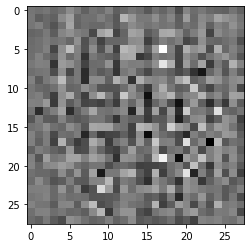

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    # model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(101,))) #为什么不是1，100
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
tf.keras.backend.clear_session() #清空会话

generator = make_generator_model()
# generator.summary()
noise = tf.random.normal((1,100))#这个tuple等同于[1,100]
# noise = tf.random.normal((100,))
y = tf.constant([[1]],dtype=tf.float32)
# y =tf.convert_to_tensor(np.array([[1,1.0]]))
noise = tf.concat([noise,y],1)
# noise = tf.concat(noise,tf.constant(1)) 这个是错的concat
# noisearr = np.array(noise)
# noisearr[0][100] = 1
print(noise.get_shape()==noise.shape,noise)
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
# y = tf.placeholder(tf.float32,[1,10])
y = tf.random.normal((5,10))
x = tf.random.normal((5,1))
tf.concat([x,y],1)

<tf.Tensor: shape=(5, 11), dtype=float32, numpy=
array([[-0.35141283,  0.01681512, -0.6409056 ,  0.89775735, -0.5175169 ,
        -0.84412754, -0.9467886 ,  0.3273531 ,  1.4899884 ,  0.27644834,
        -0.96807915],
       [ 0.17984167, -0.82349885,  0.0572947 ,  0.9880079 , -0.55481637,
         0.043413  , -1.6114926 , -2.7185323 , -1.0410141 ,  0.39756233,
        -1.2294918 ],
       [ 0.09515796,  1.7705508 ,  0.6166686 , -1.7094626 ,  1.2537582 ,
         0.06499902, -1.1043776 ,  1.5825953 , -0.17417836,  1.0757004 ,
         0.48214772],
       [ 2.077833  ,  0.01402519, -0.15879525, -0.377964  , -0.28794354,
        -0.23544687, -0.375789  , -0.4541218 , -0.68209046,  1.0492204 ,
        -0.5749927 ],
       [ 0.33256122,  0.2824891 ,  0.7507062 ,  1.4332806 , -1.1586335 ,
        -0.2568933 ,  0.8667425 ,  0.52736664,  0.59889764,  0.38634184,
        -1.5293992 ]], dtype=float32)>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=(28,28,1)))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

#     return model
def bulit_dis_net():
  model = tf.keras.Sequential()
  model.add(layers.Flatten())
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(0.2))
  # model.add(layers.Dropout(0.4))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1,activation=tf.nn.sigmoid))
  return model
# discriminator = make_discriminator_model()
discriminator = bulit_dis_net()
# discriminator.summary()


In [10]:

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49859715]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    yz = tf.concat([noise,labels])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(yz, training=True)

      real_output = discriminator([images,labels], training=True)
      fake_output = discriminator([generated_images,labels], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
r = np.array(([0,1,3],44))
r

array([list([0, 1, 3]), 44], dtype=object)